In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,precision_recall_fscore_support,accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from xgboost import XGBClassifier

In [2]:
df_pl = pd.read_csv('../../../data/all_season/Liverpool_data_epl_match_details.csv')

In [3]:
df_ldc = pd.read_csv('../../../data/all_season/Liverpool_data_ldc_match_details.csv')

In [4]:
df_ldc = df_ldc.rename(columns={'Diff_elo':'Elo_Diff',
                               'elo_liverpool':'Elo_Liverpool',
                               'elo_opponent':'Elo_Opponent',
                               'liverpool_result':'liverpool_result_ft',
                               'rest_days' : 'Rest_Days'})

In [5]:
df = df_ldc.append(df_pl[df_ldc.columns])

In [6]:
df = df.reset_index(drop=True)

#### On convertit le type des dates

In [7]:
df['date_match'] = pd.to_datetime(df['date_match'])

####  La journée de la saison correspondante

#### Si Liverpool est à domicile 0

In [8]:
df['home_0_away_1'] = df['at_anfield'].apply(lambda x : 0 if x else 1)

####  Nb points gagnes

In [9]:
df['points_won'] = df['liverpool_result_ft'].apply(lambda x : 0 if x == "D" else( 1  if x == "N" else 3))

#### Conversion de la possession pour pouvoir l'utiliser

In [10]:
df['Possession']=df['Possession'].str.replace('%','')
df['Possession']=df['Possession'].astype(int)

# Test Split

In [107]:
df = shuffle(df)

In [148]:
v_index = df[df['liverpool_result_ft'] == 'V'].head(50).index

In [149]:
n_index = df[df['liverpool_result_ft'] == 'N'].head(40).index

In [150]:
d_index = df[df['liverpool_result_ft'] == 'D'].head(40).index

In [151]:
x_train = df.loc[v_index].append(df.loc[n_index].append(df.loc[d_index]))

In [152]:
x_test = pd.concat([df, x_train, x_train]).drop_duplicates(keep=False)

In [153]:
x_train = shuffle(x_train)

In [154]:
x_test = shuffle(x_test)

In [155]:
y_train = x_train['liverpool_result_ft']

In [156]:
y_test = x_test['liverpool_result_ft']

In [157]:
x_train = x_train[['Elo_Diff','Shots','Blocks','Tackles','Corners','Crosses','Rest_Days']]

In [158]:
x_test = x_test[['Elo_Diff','Shots','Blocks','Tackles','Corners','Crosses','Rest_Days']]

In [159]:
model = XGBClassifier(max_depth=2,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5)

In [128]:
params = {
         'max_depth' : [3,4,5],
         'gamma':[2,1],
         'eta':[0.8,0.9,1],
         'reg_alpha' : [0.5,0.6],
    'reg_lambda': [0.5,0.6]
        }

In [130]:
gs = GridSearchCV(model,params,cv=5,return_train_score=False)

In [160]:
gs.fit(x_train,y_train)

c:\users\ibrah\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:32:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:32:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:32:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:32:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

KeyboardInterrupt: 

In [132]:
res = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

In [133]:
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_gamma,param_max_depth,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
58,0.175300,0.022078,0.000600,0.001200,1,2,5,0.6,0.5,"{'eta': 1, 'gamma': 2, 'max_depth': 5, 'reg_al...",0.433333,0.433333,0.533333,0.533333,0.400000,0.466667,0.055777,1
11,0.181351,0.021568,0.001799,0.001600,0.8,2,5,0.6,0.6,"{'eta': 0.8, 'gamma': 2, 'max_depth': 5, 'reg_...",0.433333,0.566667,0.533333,0.433333,0.300000,0.453333,0.093333,2
18,0.152602,0.023975,0.002004,0.001678,0.8,1,4,0.6,0.5,"{'eta': 0.8, 'gamma': 1, 'max_depth': 4, 'reg_...",0.466667,0.466667,0.433333,0.466667,0.433333,0.453333,0.016330,2
60,0.113155,0.023475,0.006851,0.007248,1,1,3,0.5,0.5,"{'eta': 1, 'gamma': 1, 'max_depth': 3, 'reg_al...",0.433333,0.533333,0.400000,0.433333,0.433333,0.446667,0.045216,4
59,0.159561,0.005410,0.004128,0.005877,1,2,5,0.6,0.6,"{'eta': 1, 'gamma': 2, 'max_depth': 5, 'reg_al...",0.433333,0.433333,0.533333,0.433333,0.400000,0.446667,0.045216,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.165160,0.019520,0.001000,0.001266,1,1,5,0.5,0.6,"{'eta': 1, 'gamma': 1, 'max_depth': 5, 'reg_al...",0.366667,0.466667,0.433333,0.333333,0.366667,0.393333,0.048990,68
33,0.168313,0.016004,0.002604,0.000492,0.9,2,5,0.5,0.6,"{'eta': 0.9, 'gamma': 2, 'max_depth': 5, 'reg_...",0.433333,0.400000,0.433333,0.333333,0.366667,0.393333,0.038873,68
30,0.141730,0.012069,0.001600,0.001357,0.9,2,4,0.6,0.5,"{'eta': 0.9, 'gamma': 2, 'max_depth': 4, 'reg_...",0.233333,0.433333,0.433333,0.433333,0.400000,0.386667,0.077746,70
68,0.174480,0.011902,0.002401,0.001200,1,1,5,0.5,0.5,"{'eta': 1, 'gamma': 1, 'max_depth': 5, 'reg_al...",0.400000,0.400000,0.333333,0.366667,0.433333,0.386667,0.033993,71


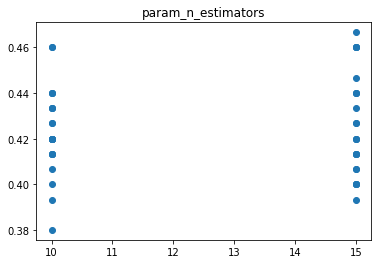

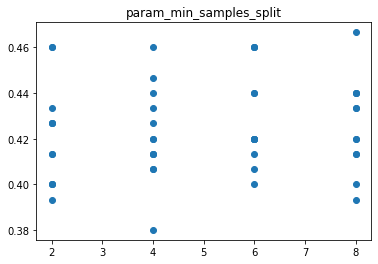

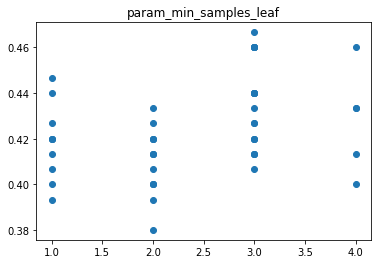

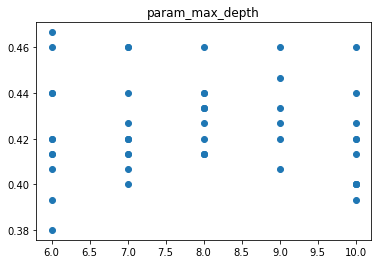

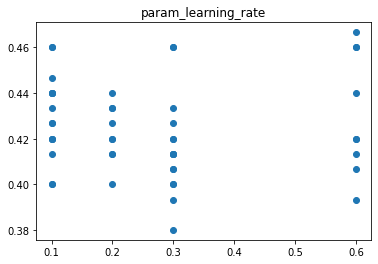

In [122]:
for col in res.columns:
    if 'param_' in col :
        plt.figure()
        plt.scatter(res[col],res['mean_test_score'])
        plt.title(col)
        plt.show()

In [100]:
res.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_min_samples_split',
       'param_min_samples_leaf', 'param_max_depth', 'param_learning_rate',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [ ]:
res.plot()

In [161]:
model.fit(x_train,y_train)

[16:33:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.8, gamma=2,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.800000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.5,
              reg_lambda=0.5, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

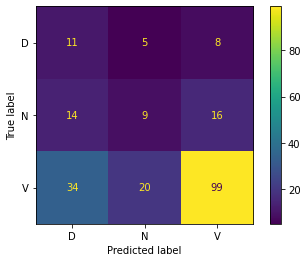

In [162]:
plot_confusion_matrix(model,x_test,y_test)
plt.show()

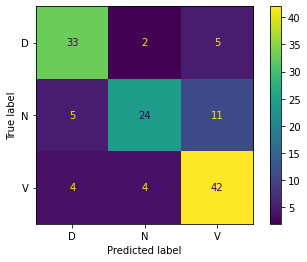

In [163]:
plot_confusion_matrix(model,x_train,y_train)
plt.show()

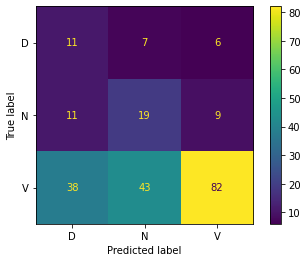

In [96]:
plot_confusion_matrix(gs.best_estimator_,x_test,y_test)
plt.show()

In [145]:
model.feature_importances_

array([0.19889875, 0.14107846, 0.16727157, 0.14091499, 0.19846992,
       0.15336627, 0.        ], dtype=float32)

In [165]:
model.feature_importances_

array([0.17059933, 0.1630338 , 0.21933287, 0.16492207, 0.15581945,
       0.1262925 , 0.        ], dtype=float32)

In [93]:
from sklearn.metrics import classification_report

In [146]:
print(classification_report(y_train, model.predict(x_train)))

              precision    recall  f1-score   support

           D       0.68      0.82      0.75        50
           N       0.64      0.58      0.61        50
           V       0.69      0.62      0.65        50

    accuracy                           0.67       150
   macro avg       0.67      0.67      0.67       150
weighted avg       0.67      0.67      0.67       150



In [164]:
print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           D       0.19      0.46      0.27        24
           N       0.26      0.23      0.25        39
           V       0.80      0.65      0.72       153

    accuracy                           0.55       216
   macro avg       0.42      0.45      0.41       216
weighted avg       0.64      0.55      0.58       216



In [97]:
print(classification_report(y_test, gs.best_estimator_.predict(x_test)))

              precision    recall  f1-score   support

           D       0.18      0.46      0.26        24
           N       0.28      0.49      0.35        39
           V       0.85      0.50      0.63       163

    accuracy                           0.50       226
   macro avg       0.43      0.48      0.41       226
weighted avg       0.68      0.50      0.54       226



# First Model with all df features

In [11]:
all_features = df.drop(columns=['date_match','home_team','away_team','season','liverpool_score_ft','opponent_score_ft',
                               'Goals','Assists','Penalties scored','Penalties won','at_anfield','points_won','Formation','contests'])

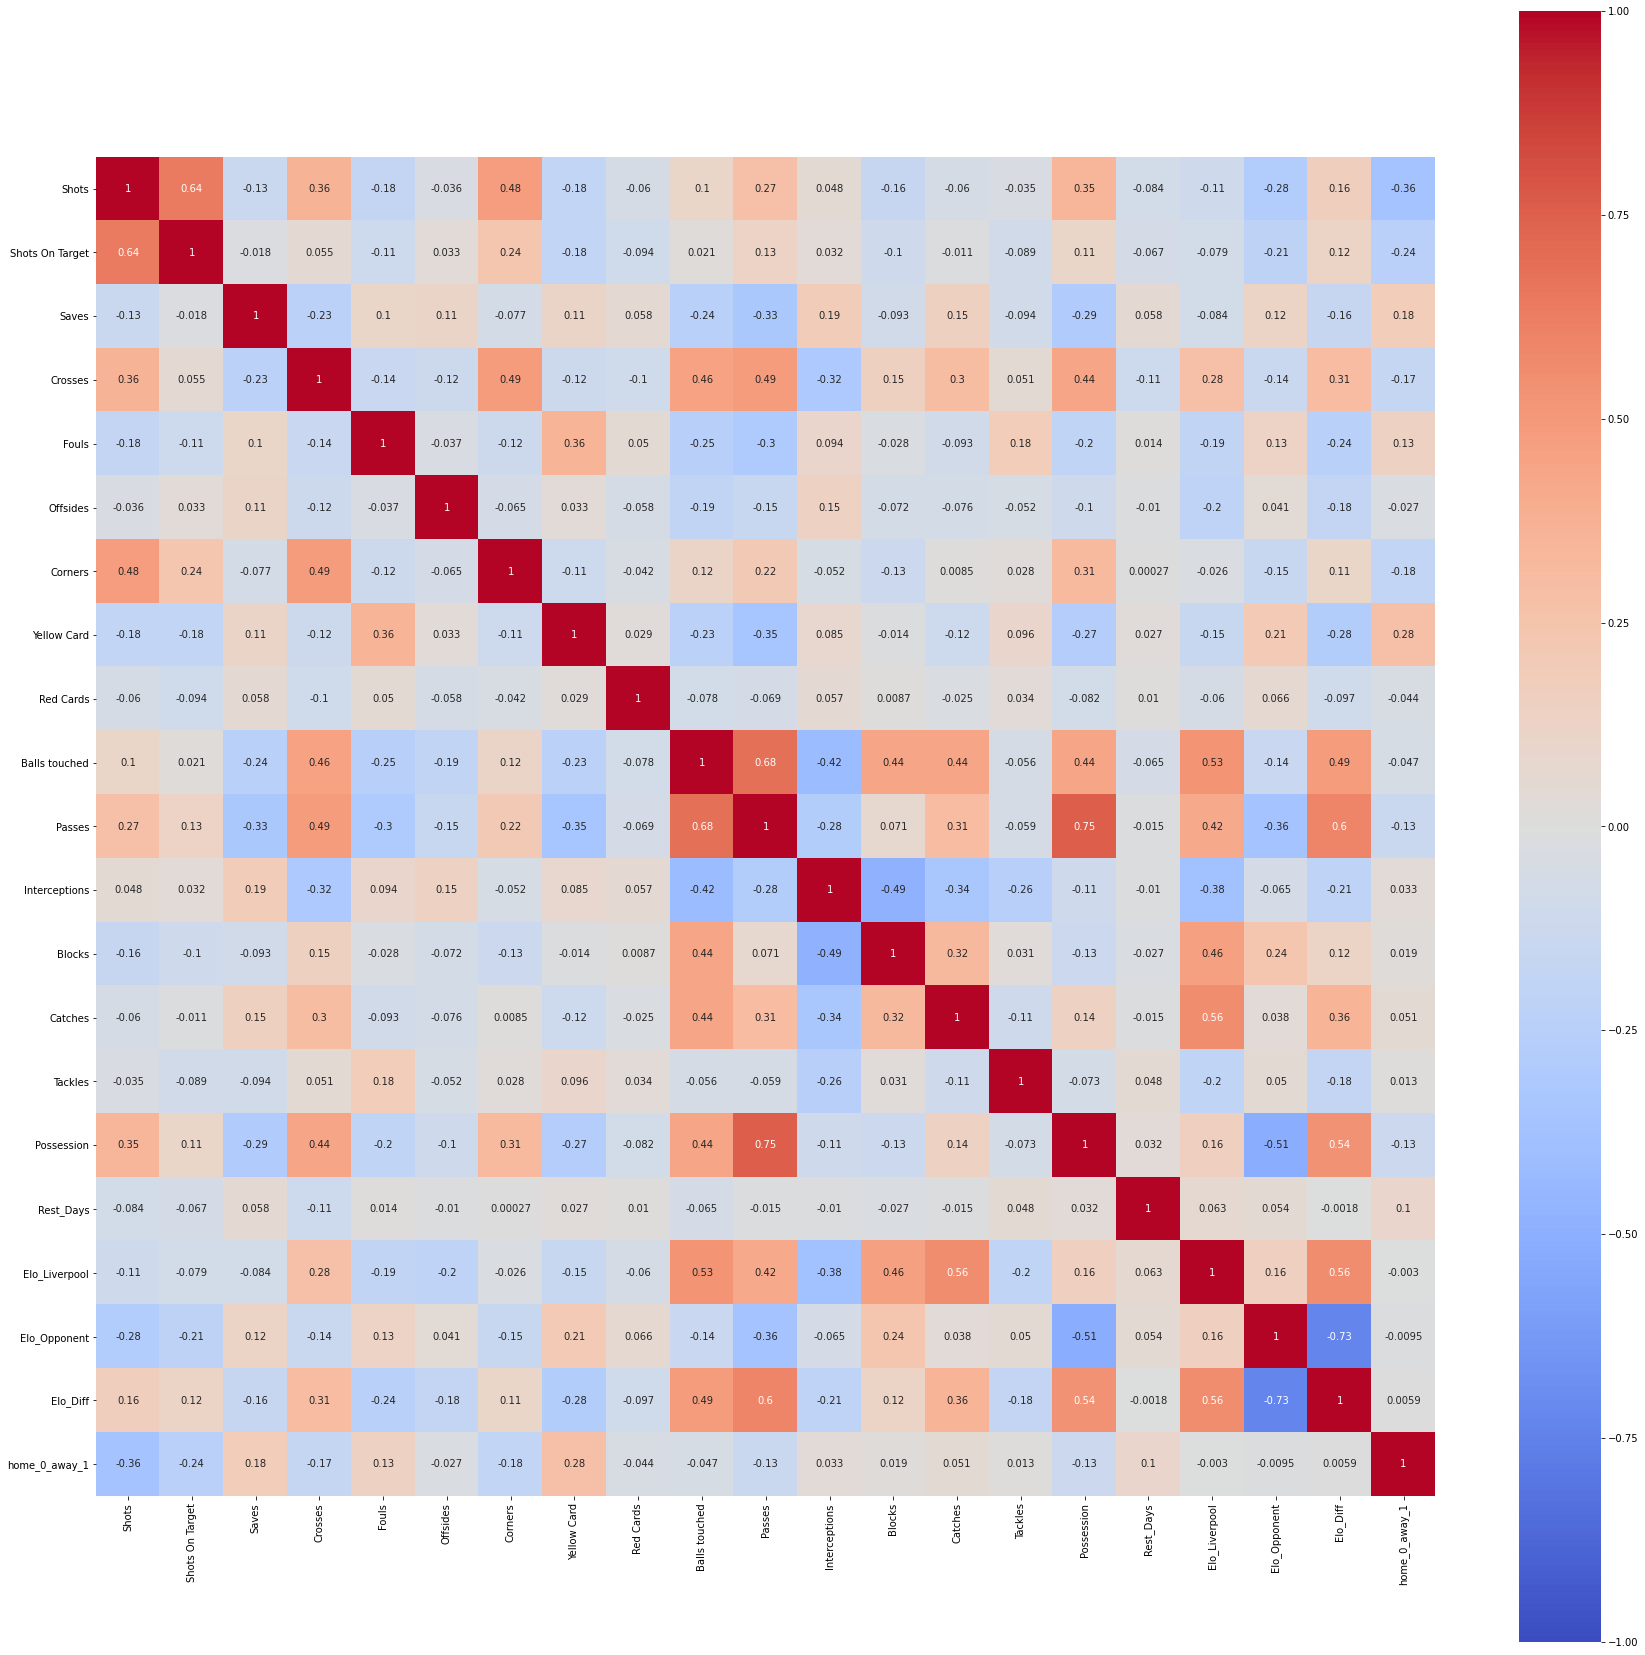

In [12]:
plt.figure(figsize=(30,30))
sns.heatmap(all_features.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True)
plt.savefig('coor.jpg')

# Supression des variables avec un corr > 0.6

In [13]:
all_features = all_features.drop(columns=['Possession','Shots On Target','Elo_Opponent','Elo_Liverpool','Balls touched'])

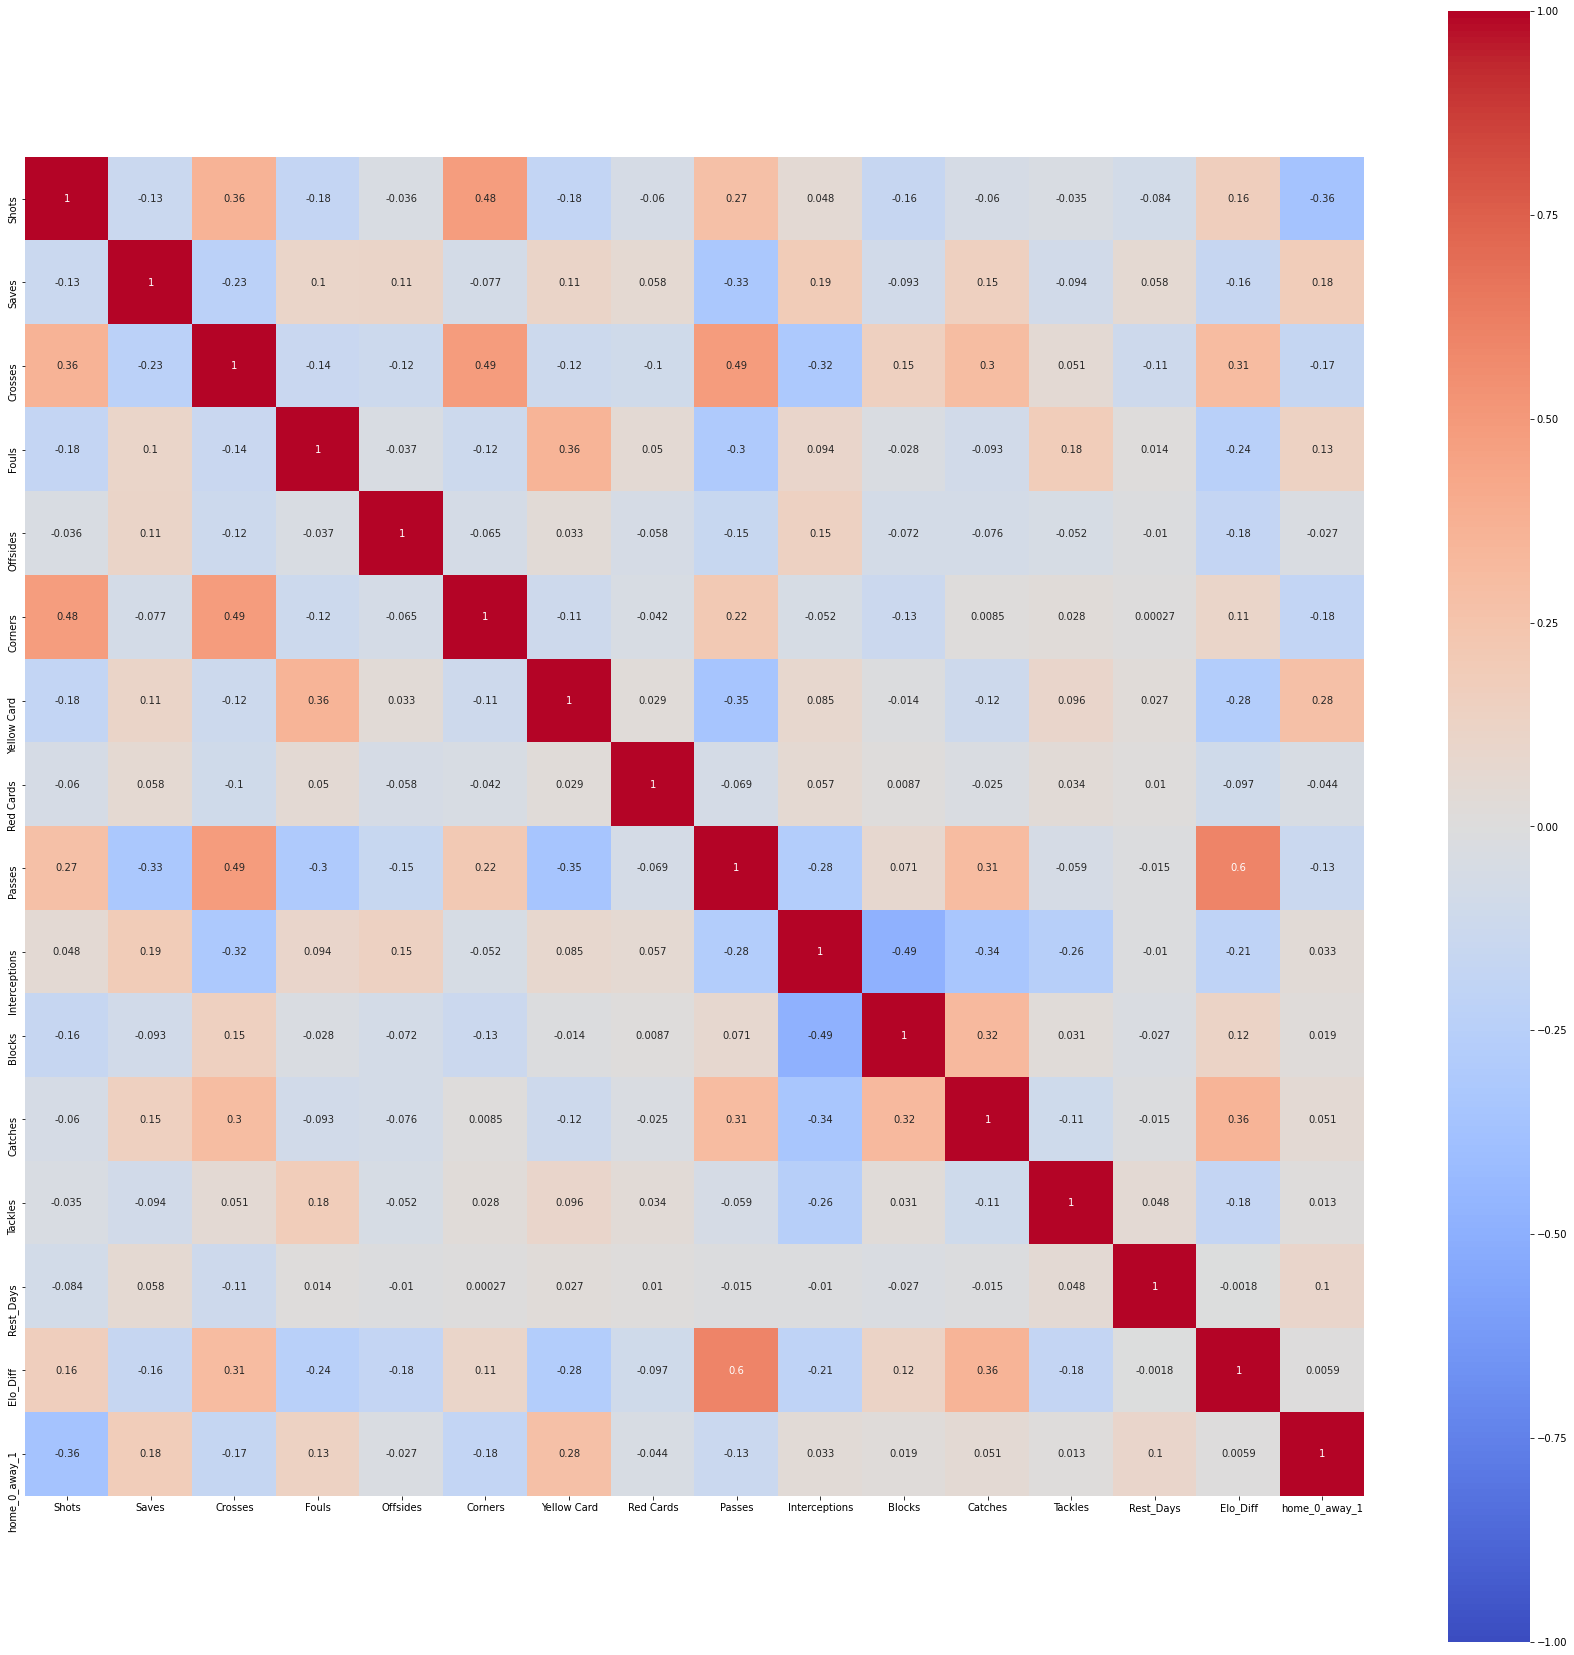

In [14]:
plt.figure(figsize=(30,30))
sns.heatmap(all_features.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True);
plt.savefig('coor.jpg')

In [25]:
all_features['liverpool_result_ft'] = df['liverpool_result_ft']

In [49]:
all_features.columns

Index(['Shots', 'Saves', 'Crosses', 'Fouls', 'Offsides', 'Corners',
       'Yellow Card', 'Red Cards', 'Passes', 'Interceptions', 'Blocks',
       'Catches', 'Tackles', 'liverpool_result_ft', 'Rest_Days', 'Elo_Diff',
       'home_0_away_1'],
      dtype='object')

In [ ]:
df['points_won']

In [53]:
lst = all_features.columns+['points_won']

In [54]:
lst

Index(['Shotspoints_won', 'Savespoints_won', 'Crossespoints_won',
       'Foulspoints_won', 'Offsidespoints_won', 'Cornerspoints_won',
       'Yellow Cardpoints_won', 'Red Cardspoints_won', 'Passespoints_won',
       'Interceptionspoints_won', 'Blockspoints_won', 'Catchespoints_won',
       'Tacklespoints_won', 'liverpool_result_ftpoints_won',
       'Rest_Dayspoints_won', 'Elo_Diffpoints_won', 'home_0_away_1points_won'],
      dtype='object')

In [55]:
tmp = df[list(all_features.columns)+['points_won']]

In [51]:
tmp

,Shots,Saves,Crosses,Fouls,Offsides,Corners,Yellow Card,Red Cards,Passes,Interceptions,Blocks,Catches,Tackles,liverpool_result_ft,Rest_Days,Elo_Diff,home_0_away_1
0,21,1,15,22,3,3,0,0,479,29,17,0,25,V,3,356.627441,0
1,15,4,22,10,7,4,3,0,268,89,2,2,7,D,4,185.473267,1
2,13,4,10,6,7,9,0,0,495,82,4,2,4,D,3,-199.485840,0
3,4,8,8,12,4,1,2,0,396,76,15,0,8,D,3,-246.692261,1
4,8,3,14,21,1,2,0,0,364,59,9,2,3,N,3,268.566650,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,19,1,32,15,0,10,4,0,431,3,17,3,8,V,3,350.940796,1
342,23,1,36,7,2,11,1,0,600,6,12,5,5,N,3,280.797241,0
343,24,0,36,10,4,13,1,0,558,6,15,5,7,D,4,198.458008,1
344,10,2,14,8,0,6,1,0,484,2,10,2,7,V,7,166.608887,0


In [56]:
df_test = pd.DataFrame(tmp.corr().unstack().sort_values(ascending=False))

In [57]:
df_test.loc['home_0_away_1']

,0
home_0_away_1,1.000000
Yellow Card,0.280318
Saves,0.180083
Fouls,0.132931
Rest_Days,0.101325
Catches,0.051230
Interceptions,0.032961
Blocks,0.018572
Tackles,0.013131
Elo_Diff,0.005867


In [41]:
df_test.index

MultiIndex([('home_0_away_1', 'home_0_away_1'),
            (     'Elo_Diff',      'Elo_Diff'),
            (        'Saves',         'Saves'),
            (      'Crosses',       'Crosses'),
            (        'Fouls',         'Fouls'),
            (     'Offsides',      'Offsides'),
            (      'Corners',       'Corners'),
            (  'Yellow Card',   'Yellow Card'),
            (    'Red Cards',     'Red Cards'),
            (       'Passes',        'Passes'),
            ...
            (       'Passes',         'Saves'),
            (        'Saves',        'Passes'),
            (      'Catches', 'Interceptions'),
            ('Interceptions',       'Catches'),
            (       'Passes',   'Yellow Card'),
            (  'Yellow Card',        'Passes'),
            (        'Shots', 'home_0_away_1'),
            ('home_0_away_1',         'Shots'),
            (       'Blocks', 'Interceptions'),
            ('Interceptions',        'Blocks')],
           length=256)

In [59]:
df1Corr=pd.DataFrame(tmp.corr().unstack().sort_values(ascending=False)['points_won'],columns=['Correlation to the target'])
df1Corr.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Correlation to the target
points_won,1.000000
Elo_Diff,0.334441
Shots,0.180931
Blocks,0.171087
Catches,0.120622
Passes,0.109069
Tackles,-0.028271
Rest_Days,-0.045971
Offsides,-0.050243
Crosses,-0.059256


# Division % choice

In [22]:
x = []
y = []

In [29]:
for per in np.linspace(0.1,0.5,30) :
    x.append(per)
    x_train, x_test, y_train, y_test = train_test_split(all_features,target,test_size = per)
    model = RandomForestClassifier()
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    y.append(accuracy_score(y_test,pred))
    

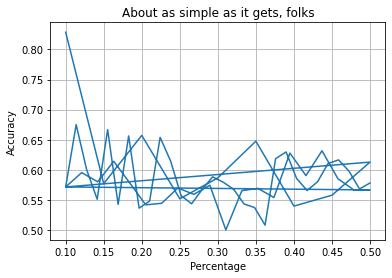

In [30]:

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='Percentage', ylabel='Accuracy',
       title='About as simple as it gets, folks')
ax.grid()

plt.show()

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

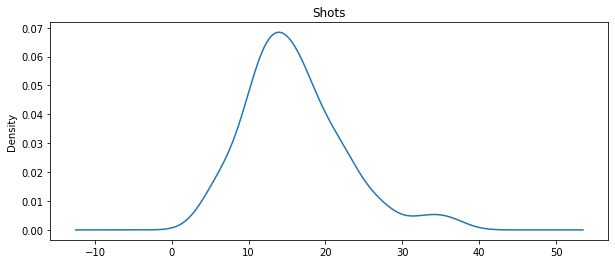

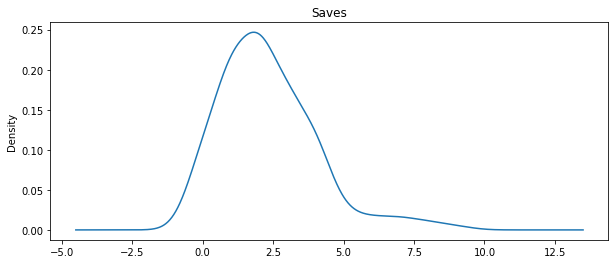

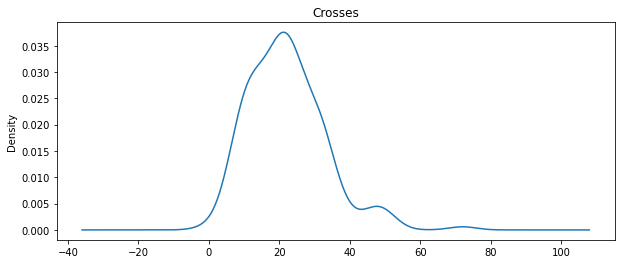

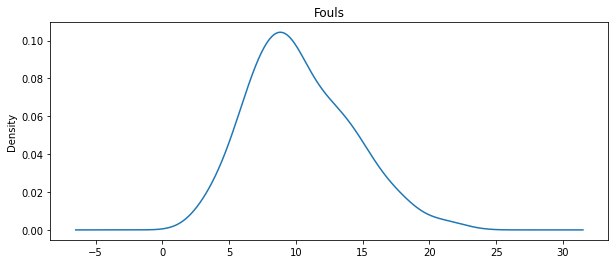

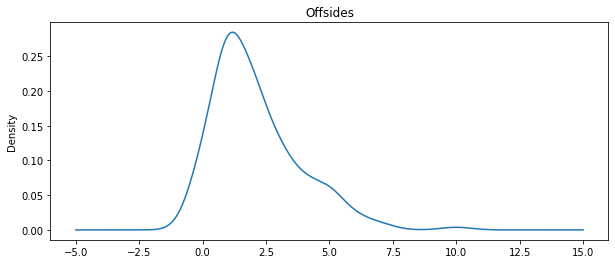

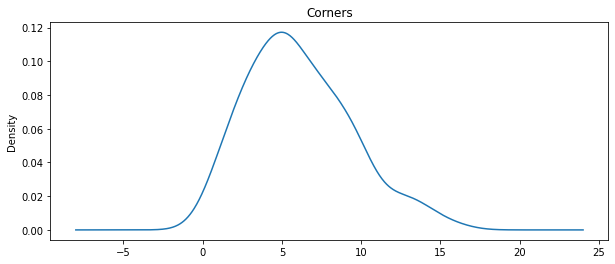

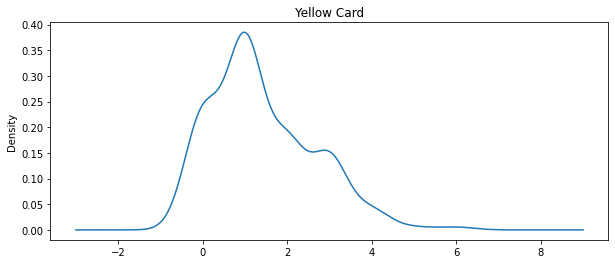

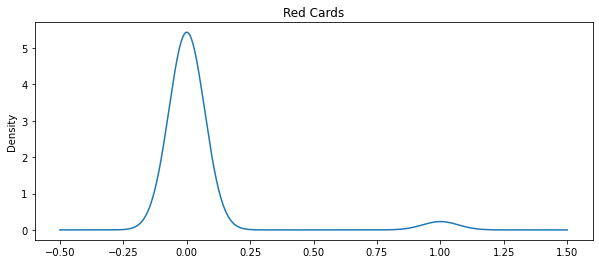

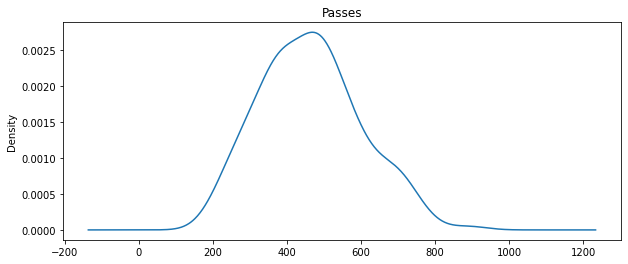

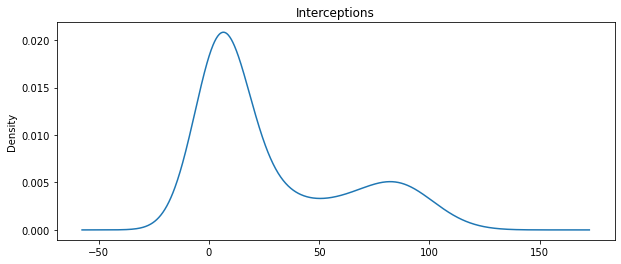

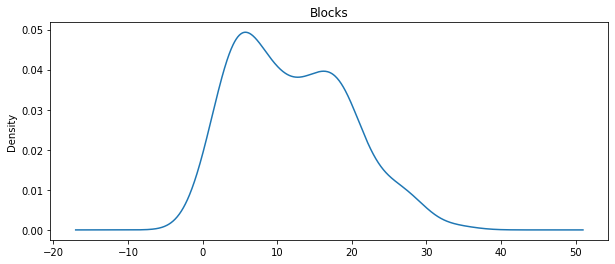

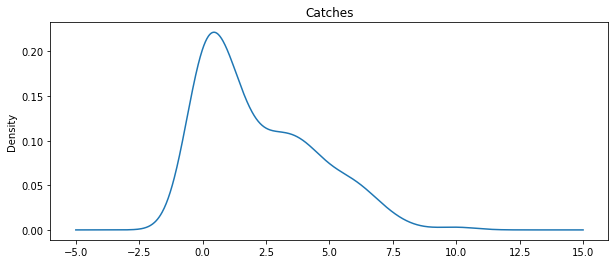

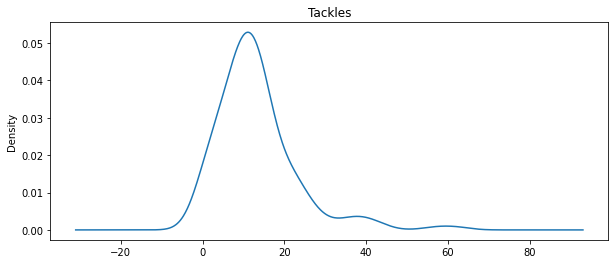

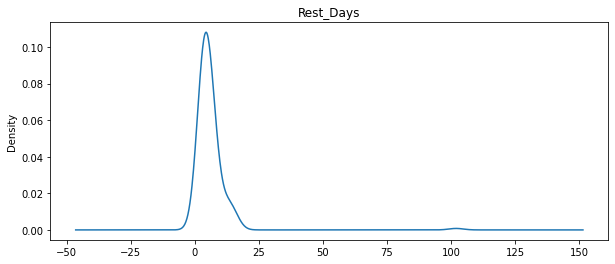

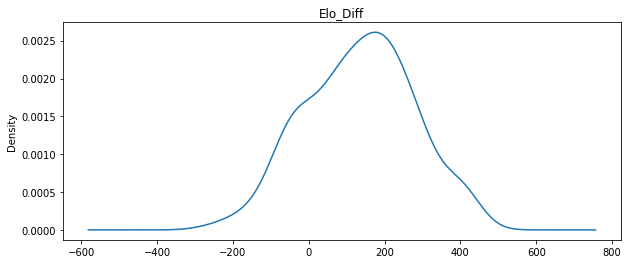

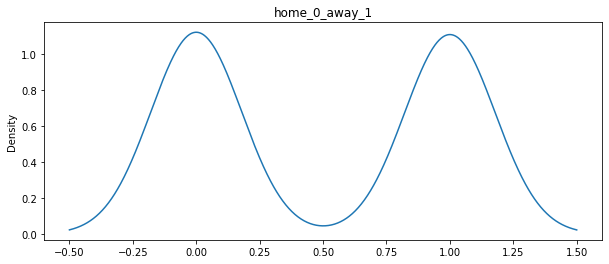

In [26]:
for col in x_train.columns : 
    fig, axes = plt.subplots(1,1, figsize=(10,4), sharey=True)
    x_train[col].plot.kde()
    axes.set_title(col)

In [88]:
categorical_cols = ['Formation','contests']

In [89]:
col_transform = make_column_transformer((OneHotEncoder(handle_unknown = 'ignore'),categorical_cols),remainder = 'passthrough')

In [18]:
x_train, x_test, y_train, y_test = train_test_split(all_features,target,test_size = 0.25)

In [19]:
model = RandomForestClassifier()

In [20]:
ppipe = Pipeline([('trans',col_transform),('mod',model)])

NameError: name 'col_transform' is not defined

In [92]:
params = {'mod__n_estimators' : [int(x) for x in np.linspace(start=5,stop=10, num=1)], 
         'mod__max_depth' : [60,70,80,90,100],
         'mod__min_samples_split':[2,4,6,8],
         'mod__min_samples_leaf':[1,2,3,4],
        }

In [21]:
params = {'n_estimators' : [10,15], 
         'max_depth' : [60,70,80,90,100],
         'min_samples_split':[2,4,6,8],
         'min_samples_leaf':[1,2,3,4],
         'bootstrap' : [True,False]
        }

In [22]:
gs = GridSearchCV(ppipe,params,cv=5,return_train_score=False)

NameError: name 'ppipe' is not defined

In [94]:
gs.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Formation',
                                                                          'contests'])])),
                                       ('mod', RandomForestClassifier())]),
             param_grid={'mod__bootstrap': [True, False],
                         'mod__max_depth': [60, 70, 80, 90, 100],
                         'mod__min_samples_leaf': [1, 2, 3, 4],
                         'mod__min_samples_split': [2, 4, 6, 8],
                         'mod__n_estimators': [5]})

In [95]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mod__bootstrap,param_mod__max_depth,param_mod__min_samples_leaf,param_mod__min_samples_split,param_mod__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
47,0.014334,0.006345,0.005399,0.001360,True,80,4,8,5,"{'mod__bootstrap': True, 'mod__max_depth': 80,...",0.657143,0.685714,0.685714,0.588235,0.617647,0.646891,0.038511,1
151,0.014033,0.005507,0.005262,0.001568,False,100,2,8,5,"{'mod__bootstrap': False, 'mod__max_depth': 10...",0.657143,0.542857,0.685714,0.735294,0.529412,0.630084,0.080795,2
3,0.011875,0.000651,0.003908,0.000655,True,60,1,8,5,"{'mod__bootstrap': True, 'mod__max_depth': 60,...",0.628571,0.714286,0.628571,0.647059,0.529412,0.629580,0.059188,3
110,0.013937,0.001957,0.004663,0.000805,False,70,4,6,5,"{'mod__bootstrap': False, 'mod__max_depth': 70...",0.657143,0.600000,0.657143,0.617647,0.588235,0.624034,0.028609,4
75,0.011311,0.000392,0.003599,0.000490,True,100,3,8,5,"{'mod__bootstrap': True, 'mod__max_depth': 100...",0.571429,0.628571,0.600000,0.676471,0.617647,0.618824,0.034699,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,0.011443,0.000489,0.003999,0.000640,True,70,1,6,5,"{'mod__bootstrap': True, 'mod__max_depth': 70,...",0.514286,0.514286,0.571429,0.529412,0.411765,0.508235,0.052577,156
48,0.018093,0.004451,0.006399,0.002875,True,90,1,2,5,"{'mod__bootstrap': True, 'mod__max_depth': 90,...",0.457143,0.485714,0.514286,0.500000,0.558824,0.503193,0.033628,157
16,0.012069,0.000640,0.003803,0.000755,True,70,1,2,5,"{'mod__bootstrap': True, 'mod__max_depth': 70,...",0.600000,0.428571,0.485714,0.470588,0.529412,0.502857,0.058302,158
0,0.027235,0.006177,0.007597,0.002416,True,60,1,2,5,"{'mod__bootstrap': True, 'mod__max_depth': 60,...",0.485714,0.514286,0.600000,0.411765,0.500000,0.502353,0.060276,159


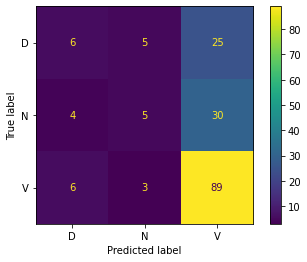

In [96]:
plot_confusion_matrix(gs.best_estimator_,x_test,y_test)
plt.show()

In [97]:
from sklearn.metrics import classification_report

In [98]:
print(classification_report(y_test, gs.best_estimator_.predict(x_test)))

              precision    recall  f1-score   support

           D       0.38      0.17      0.23        36
           N       0.38      0.13      0.19        39
           V       0.62      0.91      0.74        98

    accuracy                           0.58       173
   macro avg       0.46      0.40      0.39       173
weighted avg       0.51      0.58      0.51       173



In [101]:
lst = list(gs.best_estimator_['mod'].feature_importances_)

In [102]:
dict_ = {lst.index(x) : x for x in lst}

In [103]:
order = sorted(dict_,key = dict_.get)

In [112]:
s = 0
for i in order:
    if i >= 10:
        s += dict_[i] 
        print(f"{i} : {dict_[i]} - {x_train.columns[i-9]}")
        
print(s)

11 : 0.0028238961574294113 - Saves
25 : 0.010623329622897032 - Elo_Diff
13 : 0.01717187243112228 - Fouls
14 : 0.017706701964885628 - Offsides
17 : 0.022707855711640492 - Red Cards
16 : 0.038313026119318784 - Yellow Card
22 : 0.03902223159270695 - Tackles
21 : 0.04789872885055944 - Catches
23 : 0.052765362238672696 - contests
18 : 0.06331812384939937 - Passes
19 : 0.06894191718171662 - Interceptions
24 : 0.07164409981671924 - Rest_Days
20 : 0.08702074403222511 - Blocks
10 : 0.11247404475541388 - Shots
15 : 0.11318758435092711 - Corners
12 : 0.14486607897600265 - Crosses
0.9104855976516368


In [45]:
len(x_train['Formation'].unique())

12

# Second Model with all df features

In [14]:
all_features = df[['Elo_Diff','Shots','Blocks','Tackles','Corners','Crosses','Rest_Days']]

plt.figure(figsize=(30,30))
sns.heatmap(all_features.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True);

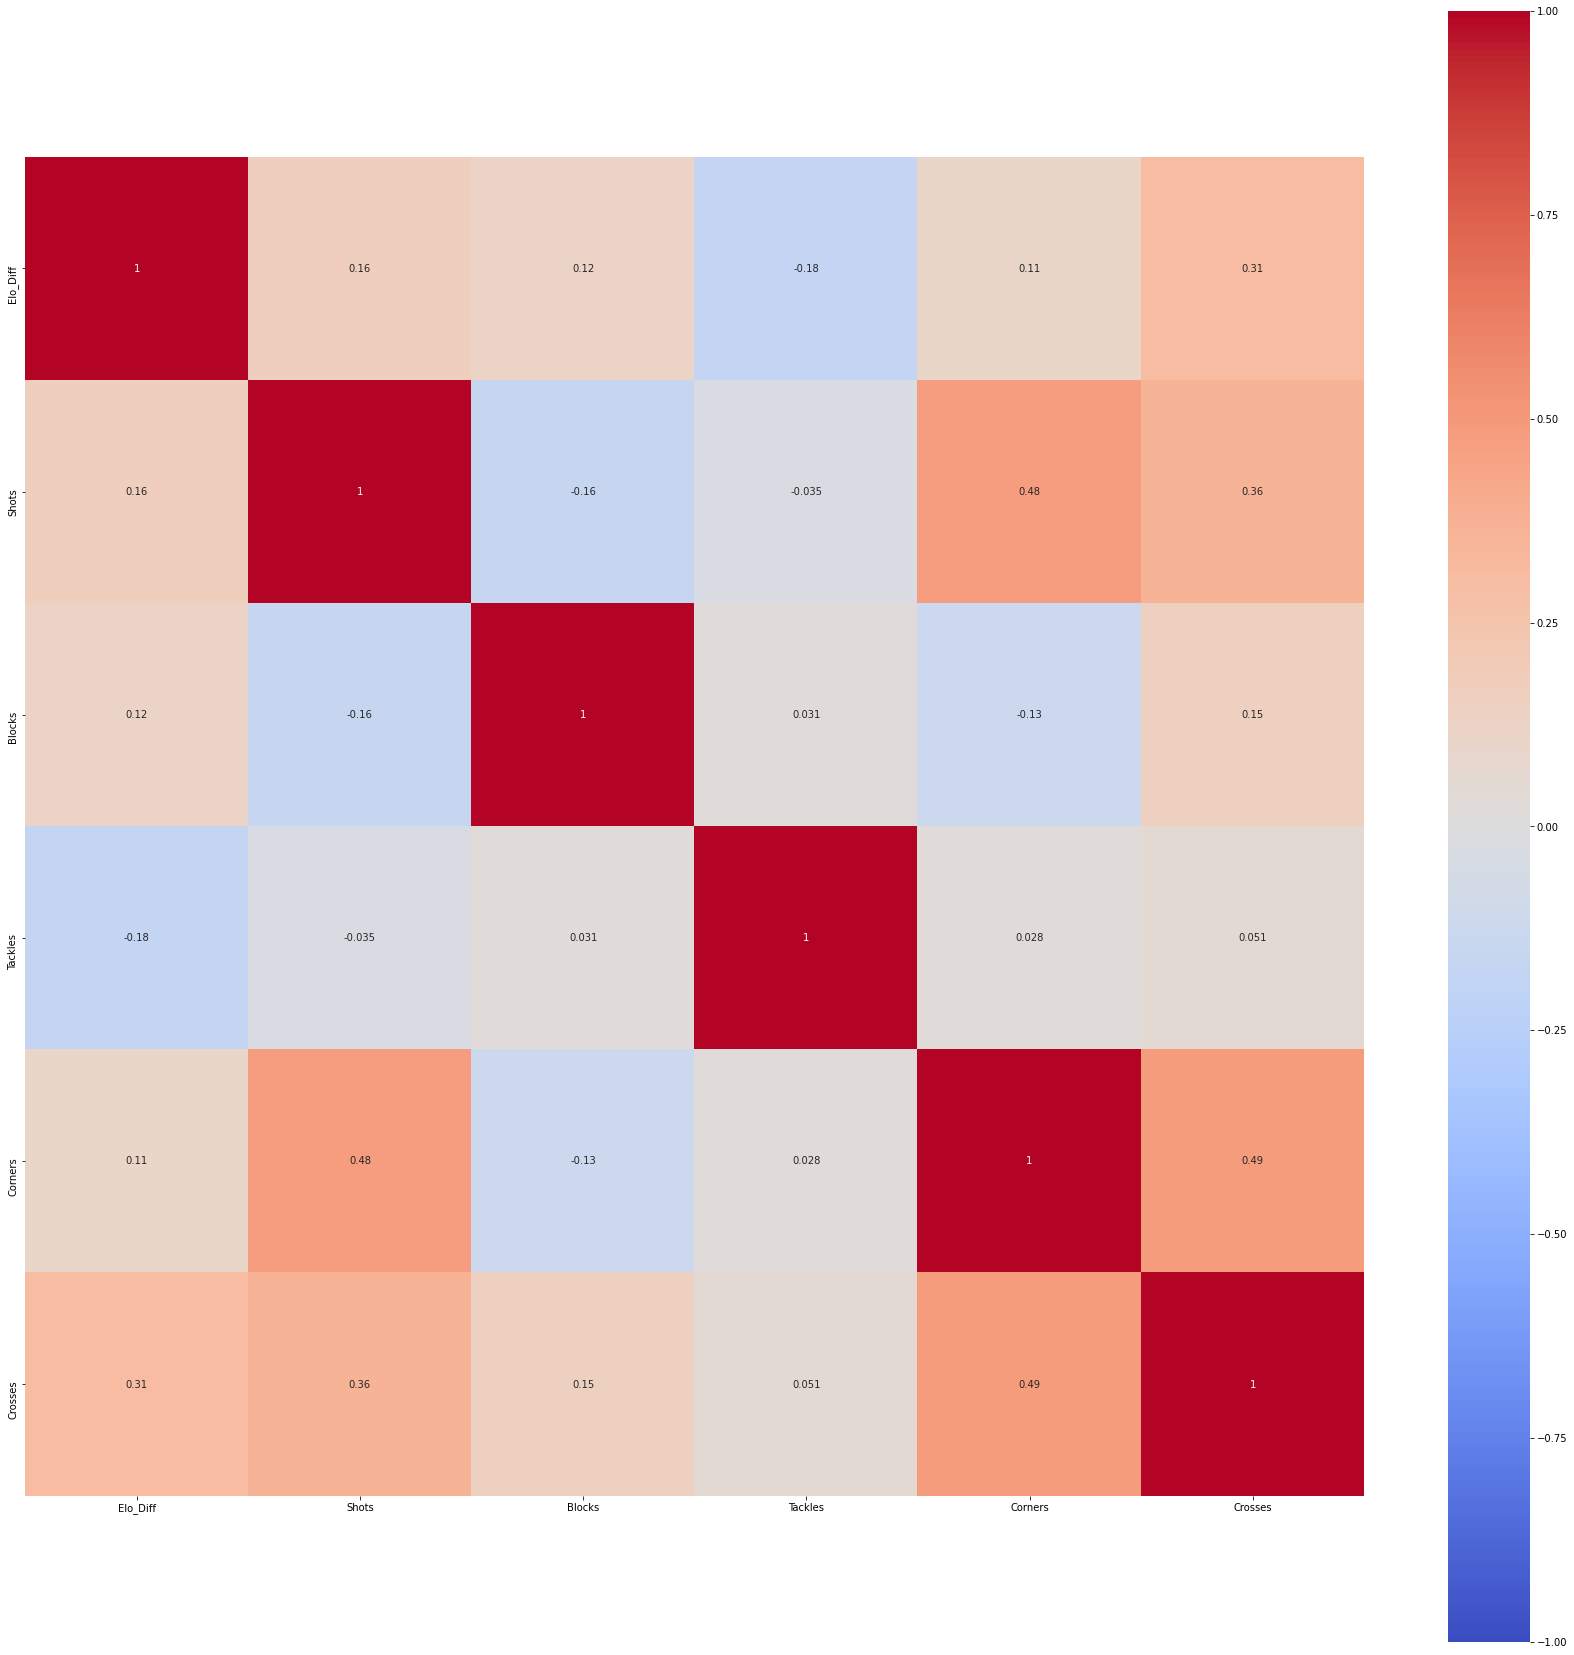

In [114]:
plt.figure(figsize=(30,30))
sns.heatmap(all_features.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True);

In [15]:
x_train, x_test, y_train, y_test = train_test_split(all_features,target,test_size = 0.25)

In [16]:
target.value_counts()

V    203
N     79
D     64
Name: liverpool_result_ft, dtype: int64

In [17]:
y_train.value_counts()

V    151
N     58
D     50
Name: liverpool_result_ft, dtype: int64

In [18]:
y_test.value_counts()

V    52
N    21
D    14
Name: liverpool_result_ft, dtype: int64

In [19]:
model = RandomForestClassifier(re)

In [20]:
model_2 = GradientBoostingClassifier()

In [21]:
params = {'n_estimators' : [10,15], 
         'max_depth' : [6,7,8,9,10],
         'min_samples_split':[2,4,6,8],
         'min_samples_leaf':[1,2,3,4],
         'learning_rate' : [0.1,0.2,0.3,0.6]
        }

In [69]:
gs = GridSearchCV(model,params,cv=5,return_train_score=False)

In [70]:
gs.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [10, 15]})

In [63]:
res = pd.DataFrame(gs.cv_results_)

In [ ]:
'max_depth':range(5,16,2),
         'min_samples_split':range(1000,2100,200),
          'min_samples_leaf':range(30,71,10),
         'learning_rate' : [0.1,0.2,0.3,0.6]
            'n_estimators':range(20,81,10),

In [99]:
params = {
         'learning_rate' : [0.1,0.2,0.3,0.6]
        }

In [25]:
gs = RandomizedSearchCV(model_2,params,cv=5,return_train_score=False,n_iter=50)

In [26]:
gs.fit(x_train,y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=50,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3, 0.6],
                                        'max_depth': [6, 7, 8, 9, 10],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [10, 15]})

In [77]:
res = pd.DataFrame(gs.cv_results_)

In [27]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.047224,0.001551,0.000000,0.000000,10,8,1,6,0.1,"{'n_estimators': 10, 'min_samples_split': 8, '...",0.576923,0.557692,0.538462,0.576923,0.647059,0.579412,0.036707,1
44,0.052362,0.006789,0.004171,0.005858,10,4,4,7,0.1,"{'n_estimators': 10, 'min_samples_split': 4, '...",0.538462,0.615385,0.538462,0.576923,0.607843,0.575415,0.032810,2
31,0.074013,0.007503,0.004355,0.005690,15,6,4,8,0.1,"{'n_estimators': 15, 'min_samples_split': 6, '...",0.557692,0.596154,0.576923,0.557692,0.588235,0.575339,0.015652,3
32,0.075292,0.006858,0.002213,0.000730,10,4,3,10,0.3,"{'n_estimators': 10, 'min_samples_split': 4, '...",0.480769,0.596154,0.596154,0.615385,0.588235,0.575339,0.048125,3
34,0.055177,0.010596,0.002000,0.001095,10,8,2,8,0.3,"{'n_estimators': 10, 'min_samples_split': 8, '...",0.557692,0.557692,0.538462,0.615385,0.588235,0.571493,0.027125,5
14,0.061120,0.005513,0.001200,0.000980,10,6,3,10,0.3,"{'n_estimators': 10, 'min_samples_split': 6, '...",0.500000,0.557692,0.557692,0.653846,0.588235,0.571493,0.050109,5
49,0.065641,0.004379,0.001002,0.001268,15,8,1,7,0.2,"{'n_estimators': 15, 'min_samples_split': 8, '...",0.538462,0.596154,0.519231,0.596154,0.588235,0.567647,0.032389,7
33,0.062417,0.004430,0.003002,0.000006,10,4,4,9,0.6,"{'n_estimators': 10, 'min_samples_split': 4, '...",0.461538,0.653846,0.519231,0.596154,0.588235,0.563801,0.066627,8
41,0.094396,0.008072,0.002205,0.001168,15,8,2,9,0.2,"{'n_estimators': 15, 'min_samples_split': 8, '...",0.538462,0.576923,0.557692,0.576923,0.568627,0.563725,0.014471,9
45,0.069789,0.006292,0.002234,0.002013,10,6,3,9,0.3,"{'n_estimators': 10, 'min_samples_split': 6, '...",0.500000,0.557692,0.557692,0.634615,0.568627,0.563725,0.042856,9


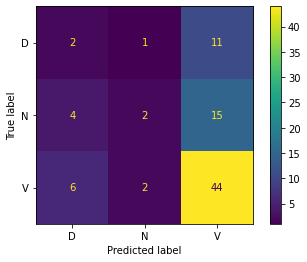

In [28]:
plot_confusion_matrix(gs.best_estimator_,x_test,y_test)
plt.show()

In [67]:
res.groupby('param_bootstrap').mean('mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
param_bootstrap,,,,,,,,,,,,
False,0.017745,0.001930,0.003536,0.001148,0.59988,0.573918,0.525481,0.491587,0.559926,0.550158,0.047786,189.34375
True,0.020721,0.003203,0.003102,0.001984,0.59387,0.580529,0.554087,0.514663,0.572549,0.563140,0.041138,128.68750


In [71]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
38,0.015198,0.000400,0.003002,0.000004,True,7,1,8,10,"{'bootstrap': True, 'max_depth': 7, 'min_sampl...",0.634615,0.615385,0.653846,0.576923,0.607843,0.617722,0.025915,1
135,0.022600,0.000491,0.003399,0.000490,True,10,1,8,15,"{'bootstrap': True, 'max_depth': 10, 'min_samp...",0.576923,0.615385,0.634615,0.615385,0.588235,0.606109,0.020765,2
2,0.014782,0.004926,0.001199,0.001468,True,6,1,4,10,"{'bootstrap': True, 'max_depth': 6, 'min_sampl...",0.634615,0.634615,0.596154,0.615385,0.549020,0.605958,0.031842,3
41,0.023670,0.006446,0.002000,0.001673,True,7,2,2,15,"{'bootstrap': True, 'max_depth': 7, 'min_sampl...",0.653846,0.653846,0.538462,0.576923,0.588235,0.602262,0.045235,4
217,0.017601,0.000489,0.003001,0.000002,False,7,4,2,15,"{'bootstrap': False, 'max_depth': 7, 'min_samp...",0.596154,0.673077,0.576923,0.519231,0.627451,0.598567,0.051292,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.013602,0.000491,0.002999,0.000002,False,9,2,2,10,"{'bootstrap': False, 'max_depth': 9, 'min_samp...",0.576923,0.500000,0.519231,0.442308,0.549020,0.517496,0.045799,316
224,0.013200,0.000402,0.003000,0.000001,False,8,1,2,10,"{'bootstrap': False, 'max_depth': 8, 'min_samp...",0.615385,0.519231,0.461538,0.442308,0.549020,0.517496,0.062231,316
265,0.019402,0.000491,0.003597,0.000489,False,9,2,2,15,"{'bootstrap': False, 'max_depth': 9, 'min_samp...",0.576923,0.519231,0.480769,0.480769,0.529412,0.517421,0.035705,318
212,0.014002,0.000002,0.003401,0.000495,False,7,3,6,10,"{'bootstrap': False, 'max_depth': 7, 'min_samp...",0.538462,0.538462,0.461538,0.423077,0.549020,0.502112,0.050469,319


In [101]:
from sklearn.metrics import classification_report

In [102]:
print(classification_report(y_test, gs.best_estimator_.predict(x_test)))

              precision    recall  f1-score   support

           D       0.33      0.24      0.28        34
           N       0.38      0.14      0.21        42
           V       0.62      0.86      0.72        97

    accuracy                           0.56       173
   macro avg       0.44      0.41      0.40       173
weighted avg       0.51      0.56      0.51       173



# Scaled Data

In [27]:
all_features = df.drop(columns=['liverpool_result_ft','date_match','home_team','away_team','season','liverpool_score_ft','opponent_score_ft',
                               'Goals','Assists','Penalties scored','Penalties won','at_anfield','points_won','Formation','contests'])

plt.figure(figsize=(30,30))
sns.heatmap(all_features.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True);

# Supression des variables avec un corr > 0.6

In [28]:
all_features = all_features.drop(columns=['Possession','Shots On Target','Elo_Opponent','Elo_Liverpool','Balls touched'])

plt.figure(figsize=(30,30))
sns.heatmap(all_features.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True);

In [74]:
x_train, x_test, y_train, y_test = train_test_split(all_features,target,test_size = 0.50)

In [75]:
model = RandomForestClassifier()

In [76]:
model.fit(x_train,y_train)

RandomForestClassifier()

In [77]:
x_scale = StandardScaler().fit_transform(x_train)

In [78]:
x_scale = pd.DataFrame(x_scale,columns=x_train.columns)

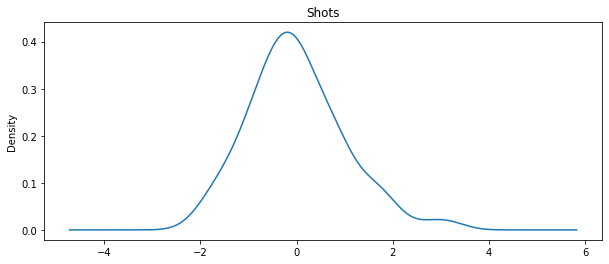

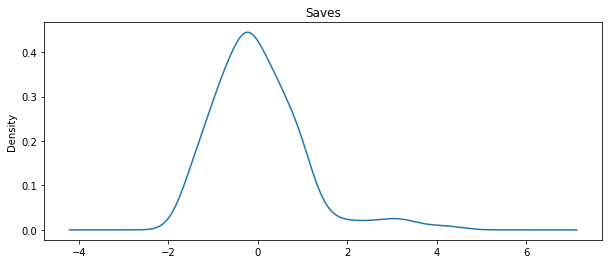

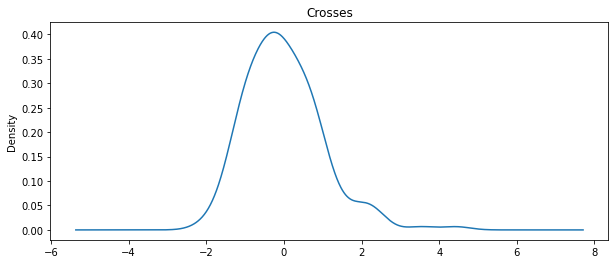

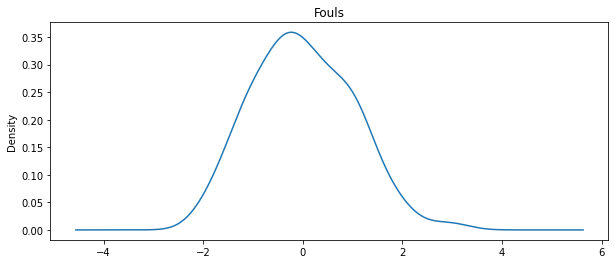

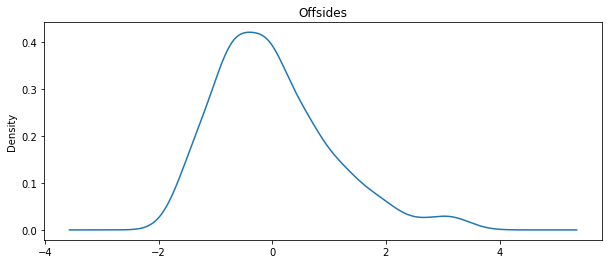

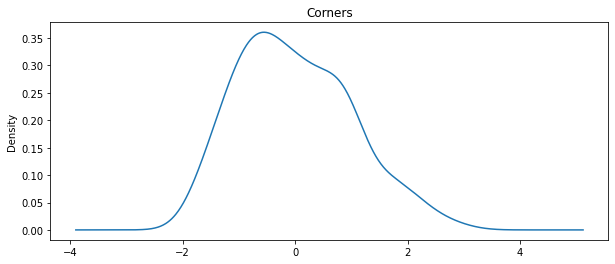

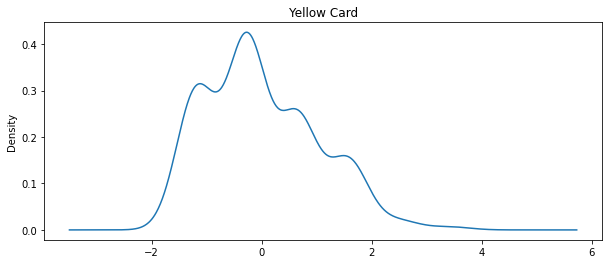

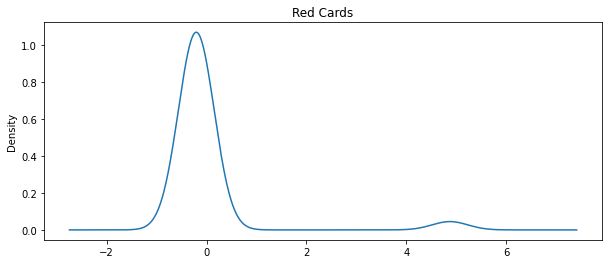

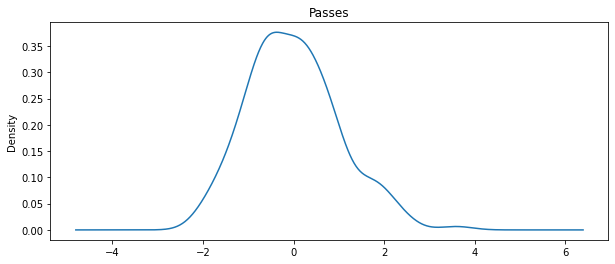

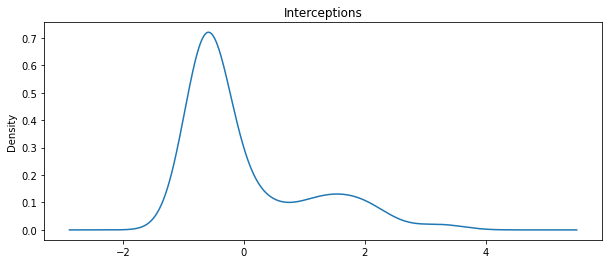

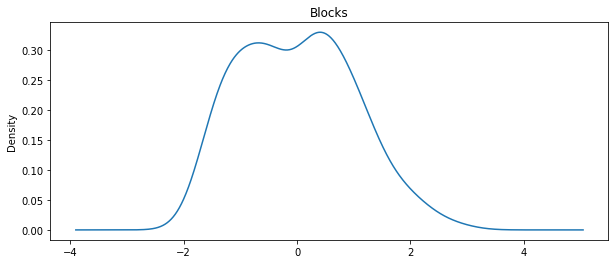

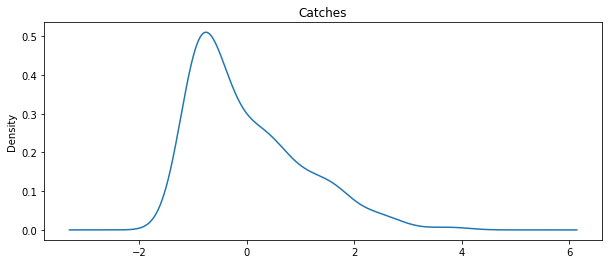

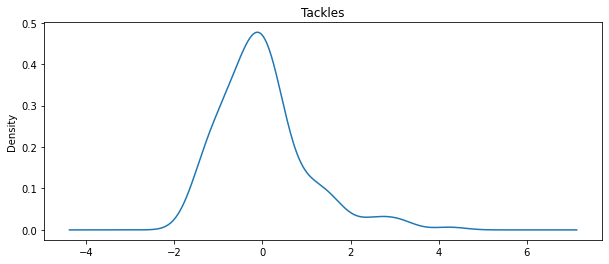

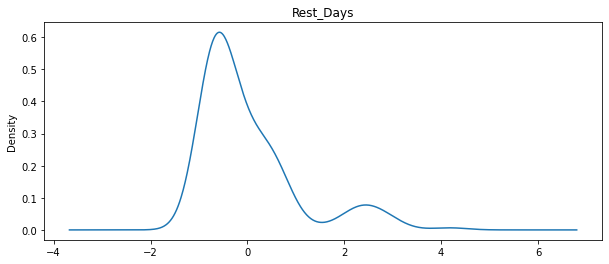

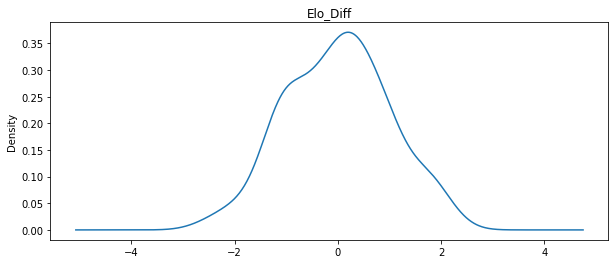

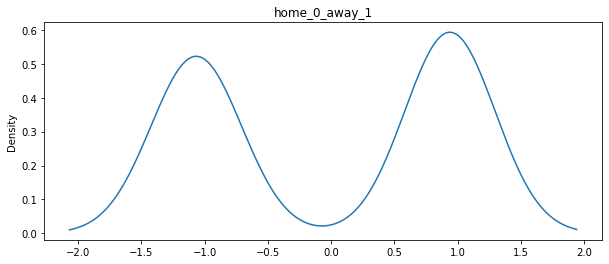

In [79]:
for col in x_scale.columns : 
    fig, axes = plt.subplots(1,1, figsize=(10,4), sharey=True)
    x_scale[col].plot.kde()
    axes.set_title(col)

In [80]:
params = {'n_estimators' : [30,40], 
         'max_depth' : [15,20,40],
         'min_samples_split':[4,6,8],
         'min_samples_leaf':[2,3,4],
         'bootstrap' : [True,False],
         'max_features': [8,11,16],
        'criterion' : ['gini']}

In [81]:
gs = GridSearchCV(model,params,cv=5,scoring='accuracy',return_train_score=False)

In [82]:
gs.fit(x_scale,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'criterion': ['gini'],
                         'max_depth': [15, 20, 40], 'max_features': [8, 11, 16],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [4, 6, 8],
                         'n_estimators': [30, 40]},
             scoring='accuracy')

In [83]:
pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
99,0.059200,0.000747,0.005000,1.173833e-06,True,gini,20,16,3,6,40,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.542857,0.685714,0.600000,0.617647,0.588235,0.606891,0.046529,1
48,0.047582,0.001415,0.000000,0.000000e+00,True,gini,15,16,4,4,30,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.542857,0.600000,0.685714,0.558824,0.617647,0.601008,0.050228,2
35,0.055214,0.011724,0.007251,7.077583e-03,True,gini,15,11,4,8,40,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.542857,0.685714,0.542857,0.529412,0.676471,0.595462,0.070150,3
139,0.054678,0.009636,0.008409,6.163546e-03,True,gini,40,11,4,4,40,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.514286,0.628571,0.657143,0.588235,0.588235,0.595294,0.048155,4
110,0.046881,0.000012,0.000000,0.000000e+00,True,gini,40,8,2,6,30,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.514286,0.600000,0.685714,0.588235,0.588235,0.595294,0.054516,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.053800,0.002038,0.005401,7.997300e-04,False,gini,15,16,4,4,40,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.457143,0.514286,0.628571,0.500000,0.441176,0.508235,0.065867,320
318,0.041354,0.008477,0.003127,6.253719e-03,False,gini,40,16,4,4,30,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.457143,0.514286,0.628571,0.500000,0.441176,0.508235,0.065867,320
215,0.053400,0.002053,0.005199,4.000444e-04,False,gini,15,16,4,8,40,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.457143,0.514286,0.628571,0.500000,0.441176,0.508235,0.065867,320
213,0.053996,0.001786,0.005000,1.784161e-07,False,gini,15,16,4,6,40,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.457143,0.514286,0.628571,0.500000,0.441176,0.508235,0.065867,320


In [84]:
y_scale = StandardScaler().fit_transform(x_test)

In [85]:
y_scale = pd.DataFrame(y_scale,columns=x_test.columns)

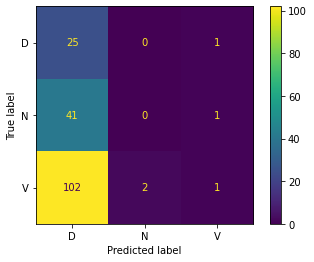

In [86]:
plot_confusion_matrix(gs.best_estimator_,x_test,y_test)
plt.show()

In [87]:
from sklearn.metrics import classification_report

In [88]:
print(classification_report(y_test, gs.best_estimator_.predict(y_scale)))

              precision    recall  f1-score   support

           D       0.17      0.19      0.18        26
           N       0.35      0.14      0.20        42
           V       0.67      0.81      0.73       105

    accuracy                           0.55       173
   macro avg       0.40      0.38      0.37       173
weighted avg       0.52      0.55      0.52       173

